Data Preparartion

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [5]:
path = '/content/drive/My Drive/RottenVsFresh/FruitFreshnessDataset'
os.listdir(path)


['Apple', 'Strawberry', 'Banana']

In [6]:
strawberry_path = os.path.join(path, 'Strawberry')
apple_path = os.path.join(path, 'Apple')
banana_path = os.path.join(path, 'Banana')

print(f"Strawberry directory: {strawberry_path}")
print(f"Apple directory: {apple_path}")
print(f"Banana directory: {banana_path}")

Strawberry directory: /content/drive/My Drive/RottenVsFresh/FruitFreshnessDataset/Strawberry
Apple directory: /content/drive/My Drive/RottenVsFresh/FruitFreshnessDataset/Apple
Banana directory: /content/drive/My Drive/RottenVsFresh/FruitFreshnessDataset/Banana


In [7]:
print(f"Strawberry directory: {os.listdir(strawberry_path)}")
print(f"Apple directory: {os.listdir(apple_path)}")
print(f"Banana directory: {os.listdir(banana_path)}")

Strawberry directory: ['Fresh', 'Rotten']
Apple directory: ['Fresh', 'Rotten']
Banana directory: ['Fresh', 'Rotten']


In [8]:
labels = []
images = []

fruit_types = os.listdir(path)

for fruit_type in fruit_types:
    fruit_dir = os.path.join(path, fruit_type)

    if os.path.isdir(fruit_dir):
      freshness_types = os.listdir(fruit_dir)

      for freshness_type in freshness_types:
          freshness_dir = os.path.join(fruit_dir, freshness_type)

          if os.path.isdir(freshness_dir):
             for image_filename in os.listdir(freshness_dir):
                 if image_filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    image_path = os.path.join(freshness_dir, image_filename)
                    images.append(image_path)
                    labels.append(freshness_type)

print(f"Collected {len(images)} images and {len(labels)} labels.")

Collected 529 images and 529 labels.


In [9]:
df = pd.DataFrame({'image_path': images, 'label': labels})
df.head()

,image_path,label
0,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh
1,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh
2,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh
3,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh
4,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh


Text(0.5, 0, 'Label')

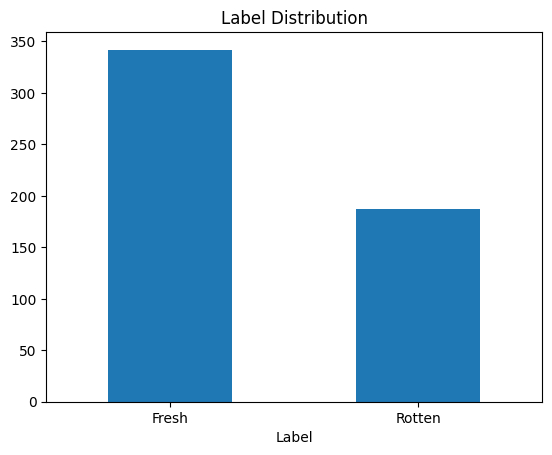

In [10]:
df['label'].value_counts(ascending=False).plot(kind='bar', title='Label Distribution')
plt.xticks(rotation=0)
plt.xlabel('Label')

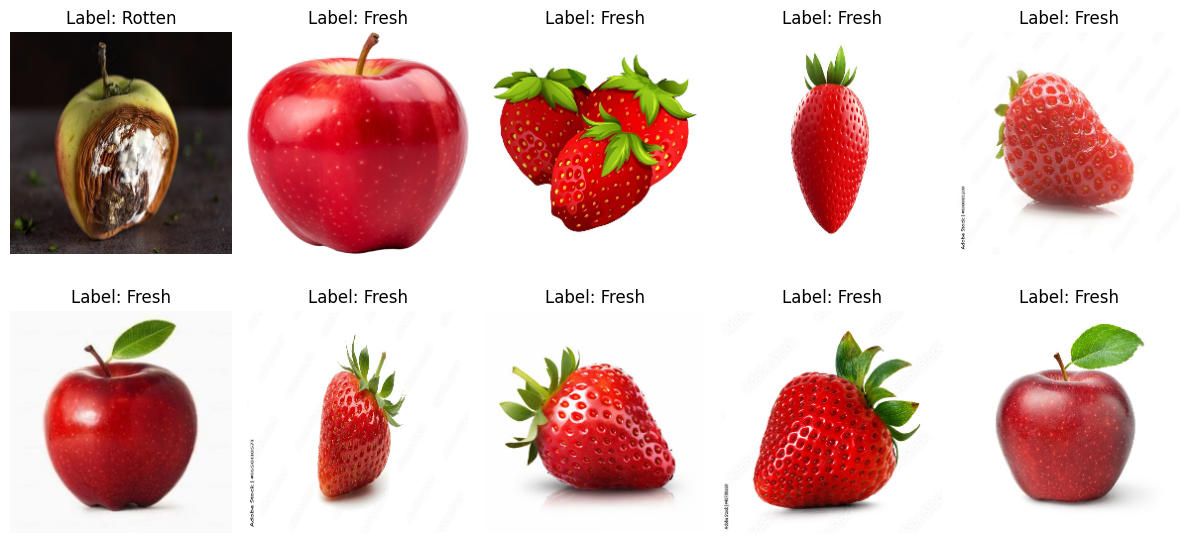

In [11]:
import cv2
labels = df['label'].unique()

plt.figure(figsize=(12, 6))

for i in range(10):
  random_index = random.randint(0, len(df) - 1)
  image_path = df.iloc[random_index]['image_path']
  label = df.iloc[random_index]['label']

  img = plt.imread(image_path).copy()
  resized_img = cv2.resize(img, (224, 224))
  plt.subplot(2, 5, i+1)
  plt.imshow(resized_img)
  plt.title(f"Label: {label}")
  plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['image_path'], df['label'], test_size=0.2, random_state=42)

train_df = pd.DataFrame({'image_path': X_train, 'label': y_train})
test_df = pd.DataFrame({'image_path': X_test, 'label': y_test})

In [13]:
train_df.shape

(423, 2)

Data Processing

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.model_selection import train_test_split

train_augmentation_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(
    rescale=1./255
)

In [15]:
train_dataset = train_augmentation_gen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

test_dataset = test_gen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 423 validated image filenames belonging to 2 classes.
Found 106 validated image filenames belonging to 2 classes.


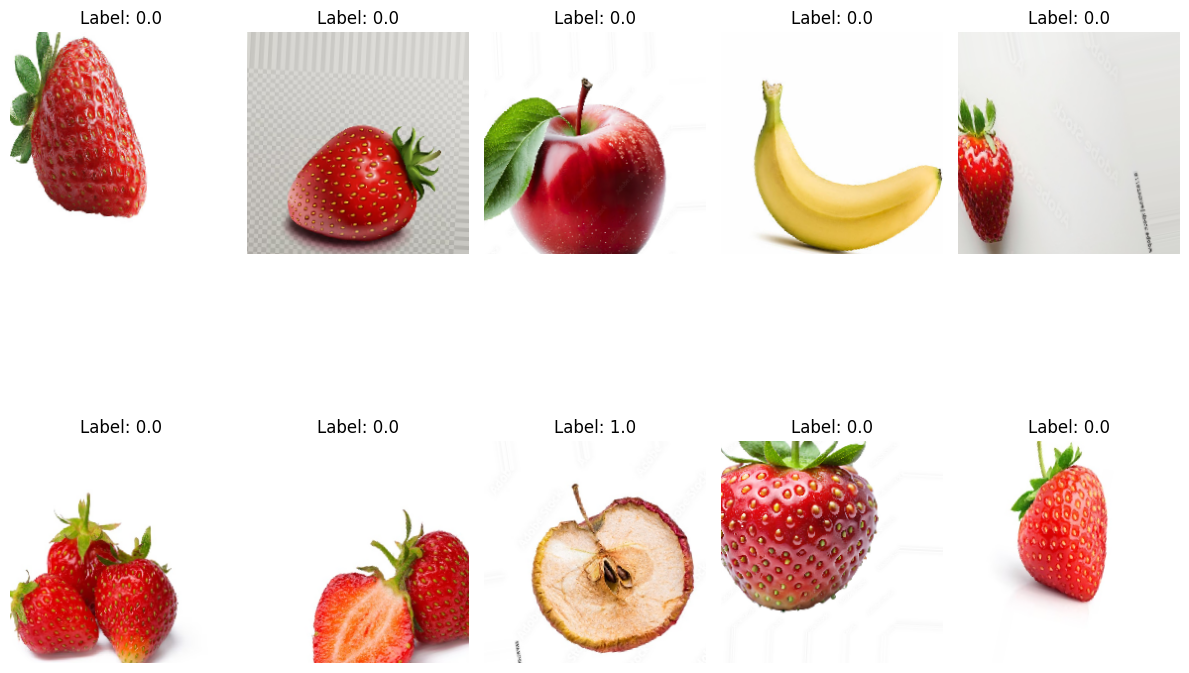

In [16]:
# Visualizing some train data augmented
images, labels = next(train_dataset)

plt.figure(figsize=(12, 10))
for i in range(10):
  plt.subplot(2, 5, i+1)
  plt.imshow(images[i])
  plt.title(f"Label: {labels[i]}")
  plt.axis('off')

plt.tight_layout()
plt.show()

Creating model

In [17]:
# Setting up callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

model_checkpoint = ModelCheckpoint(
    filepath='best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input

model = Sequential([
    Input(shape=(224, 224, 3)),
    # First layer
    Conv2D(32, kernel_size=3, activation='relu'),
    MaxPooling2D(),

    # Second layer
    Conv2D(64, kernel_size=3, activation='relu'),
    MaxPooling2D(),

    # Third layer
    Conv2D(128, kernel_size=3, activation='relu'),
    MaxPooling2D(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
], name='model')

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
model_history = model.fit(
    train_dataset,
    steps_per_epoch=len(train_dataset),
    validation_data=test_dataset,
    validation_steps=len(test_dataset),
    epochs=15,
    callbacks=[early_stopping, model_checkpoint, lr_scheduler]
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6383 - loss: 0.6534
Epoch 1: val_loss improved from inf to 0.55801, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 78s 6s/step - accuracy: 0.6400 - loss: 0.6525 - val_accuracy: 0.7170 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7101 - loss: 0.5757
Epoch 2: val_loss improved from 0.55801 to 0.42477, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 60s 4s/step - accuracy: 0.7107 - loss: 0.5747 - val_accuracy: 0.7830 - val_loss: 0.4248 - learning_rate: 0.0010
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.7900 - loss: 0.4630
Epoch 3: val_loss improved from 0.42477 to 0.28616, saving model to best_model.keras
14/14 ━━━━━━━━━━━━━━━━━━━━ 56s 4s/step - accuracy: 0.7922 - loss: 0.4606 - val_accuracy: 0.8962 - val_loss: 0.2862 - learning_rate: 0.0010
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8264 - loss: 0.3832


In [25]:
def plot_history(history):
  acc = history.history['accuracy']
  loss = history.history['loss']

  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(epochs, acc, 'r', label='Training Accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(epochs, loss, 'r', label='Training Loss')
  plt.plot(epochs, val_loss, 'b', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()


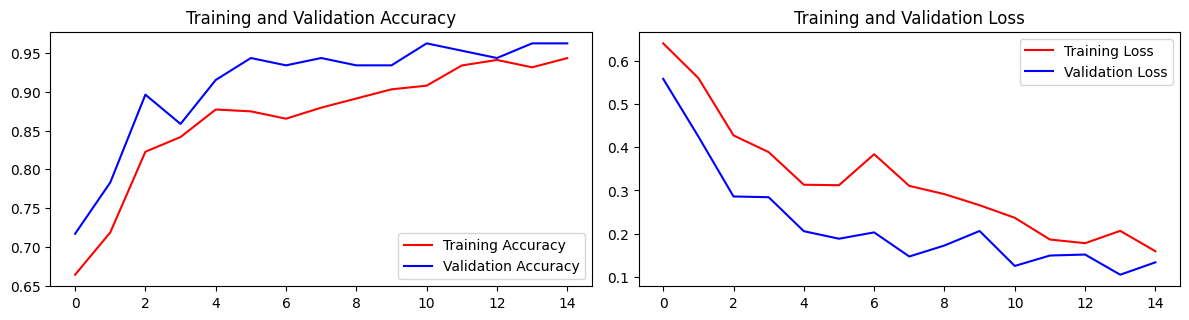

In [26]:
  plot_history(model_history)

Testing

In [27]:
model.evaluate(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9703 - loss: 0.0858


[0.1053011491894722, 0.9622641801834106]

In [28]:
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')
preds = model.predict(test_dataset)

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 976ms/step


In [29]:
import numpy as np

class_indices = train_dataset.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}
# Corrected prediction for binary classification
predicted_class_indices = (preds > 0.5).astype(int).flatten() # Threshold at 0.5 and flatten
predicted_classes = [idx_to_class[idx] for idx in predicted_class_indices]
print("First 10 predicted class labels")
for i, label in enumerate(predicted_classes[:10]):
  print(f"Image {i+1}: {label}")
test_df['predicted_label'] = predicted_classes
display(test_df.head(10))

First 10 predicted class labels
Image 1: Rotten
Image 2: Rotten
Image 3: Fresh
Image 4: Fresh
Image 5: Fresh
Image 6: Fresh
Image 7: Fresh
Image 8: Rotten
Image 9: Rotten
Image 10: Fresh


,image_path,label,predicted_label
140,/content/drive/My Drive/RottenVsFresh/FruitFre...,Rotten,Rotten
397,/content/drive/My Drive/RottenVsFresh/FruitFre...,Rotten,Rotten
6,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh
334,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh
322,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh
82,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh
225,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh
495,/content/drive/My Drive/RottenVsFresh/FruitFre...,Rotten,Rotten
522,/content/drive/My Drive/RottenVsFresh/FruitFre...,Rotten,Rotten
101,/content/drive/My Drive/RottenVsFresh/FruitFre...,Fresh,Fresh


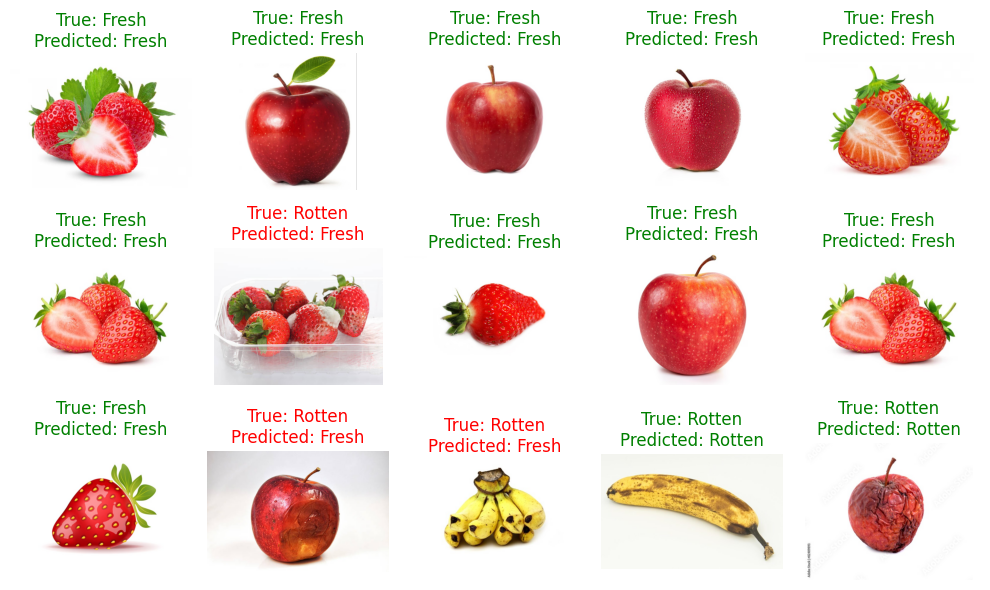

In [30]:
 # Visualizing predictions

fig, ax = plt.subplots(3, 5, figsize=(10, 6))
ax = ax.ravel()
for i in range(15):
  idx = random.randint(0, len(test_df) - 1)
  image_path = test_df.iloc[idx]['image_path']
  true_label = test_df.iloc[idx]['label']
  predicted_label = test_df.iloc[idx]['predicted_label']
  if true_label == predicted_label:
    color = 'green'
  else:
    color = 'red'
  img = plt.imread(image_path)
  ax[i].imshow(img)
  ax[i].set_title(f"True: {true_label}\nPredicted: {predicted_label}", color=color)
  ax[i].axis('off')

plt.tight_layout()
plt.show()